In [1]:
import copy

import cvrplib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd

from alns import ALNS, State
from alns.accept import RecordToRecordTravel
from alns.select import RouletteWheel
from alns.stop import MaxRuntime

In [2]:
%matplotlib inline

In [3]:
SEED = 1234

In [4]:
# data, bks = cvrplib.read('data/ORTEC-n242-k12.vrp', 'data/ORTEC-n242-k12.sol')
data = cvrplib.read('data/C101.txt')

print(data.name)
print(data.dimension)
print(data.capacity)
print(data.demands)
# print(type(data.distances))
print(data.service_times)

C101
101
200
[0, 10, 30, 10, 10, 10, 20, 20, 20, 10, 10, 10, 20, 30, 10, 40, 40, 20, 20, 10, 10, 20, 20, 10, 10, 40, 10, 10, 20, 10, 10, 20, 30, 40, 20, 10, 10, 20, 30, 20, 10, 10, 20, 10, 10, 10, 30, 10, 10, 10, 10, 10, 10, 20, 40, 10, 30, 40, 30, 10, 20, 10, 20, 50, 10, 10, 10, 10, 10, 10, 30, 20, 10, 10, 50, 20, 10, 10, 20, 10, 10, 30, 20, 10, 20, 30, 10, 20, 30, 10, 10, 10, 20, 40, 10, 30, 10, 30, 20, 10, 20]
[0, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90]


In [5]:
import alns_state.state as st

In [6]:
initial_state = st.nearest_neighbor(data)
initial_state.routes

[[21, 22, 23, 26, 28, 30, 27, 25, 24, 29, 20, 43, 42],
 [67, 65, 63, 62, 74, 72, 61, 64, 68, 69, 66],
 [5, 3, 4, 6, 8, 9, 11, 10, 7, 1, 2, 75, 91, 89],
 [47, 49, 52, 50, 51, 48, 45, 44, 40, 41, 46, 59, 57, 55],
 [90, 87, 86, 84, 85, 88, 83, 82, 81, 78],
 [98, 96, 95, 94, 93, 92, 97, 100, 99],
 [13, 17, 18, 19, 15, 14, 16, 12],
 [34, 36, 39, 38, 37, 35, 31, 33, 32],
 [54, 53, 56, 58, 60, 80, 79, 77, 73],
 [76, 71, 70]]

In [7]:
from alns_operator import removal as rm
# import operator.removal as rm

In [8]:
# curr = rm.random_removal(initial_state, rnd.RandomState(SEED))
# print(curr.cost)

In [9]:
removal = rm.Removal(5, 2)

In [10]:
curr = removal.remove_specific_customer(initial_state, 29)
print(curr.cost)

1040


In [11]:
# sorted_cost = removal.sort_desc_cost_request(initial_state)
# print(sorted_cost)

In [12]:
curr = removal.worst_removal(initial_state, rnd.RandomState(SEED))
print(curr.cost)
print(curr.routes)

1036
[[21, 22, 23, 26, 28, 30, 27, 25, 24, 29, 20, 43, 42], [67, 65, 63, 62, 74, 72, 61, 64, 68, 69], [5, 3, 4, 6, 8, 9, 11, 10, 7, 1, 2, 75, 89], [47, 49, 52, 50, 51, 48, 45, 44, 40, 41, 46, 59, 57], [90, 87, 86, 84, 85, 88, 83, 82, 81, 78], [98, 96, 95, 94, 92, 97, 100, 99], [13, 17, 18, 19, 15, 14, 16, 12], [34, 36, 39, 38, 37, 35, 31, 33, 32], [54, 53, 56, 58, 60, 80, 79, 77, 73], [76, 71]]


In [13]:
def greedy_repair(state: st.CvrpState, rnd_state: rnd.RandomState):
    """
    Inserts the unassigned customers in the best route. If there are no
    feasible insertions, then a new route is created.
    """
    rnd_state.shuffle(state.unassigned)

    while len(state.unassigned) != 0:
        customer = state.unassigned.pop()
        route, idx = best_insert(customer, state)

        if route is not None:
            route.insert(idx, customer)
        else:
            state.routes.append([customer])

    return state


def best_insert(customer: int, state: st.CvrpState):
    """
    Finds the best feasible route and insertion idx for the customer.
    Return (None, None) if no feasible route insertions are found.
    """
    best_cost, best_route, best_idx = None, None, None

    for route in state.routes:
        for idx in range(len(route) + 1):

            if can_insert(customer, route):
                cost = insert_cost(customer, route, idx)

                if best_cost is None or cost < best_cost:
                    best_cost, best_route, best_idx = cost, route, idx

    return best_route, best_idx


def can_insert(customer, route):
    """
    Checks if inserting customer does not exceed vehicle capacity.
    """
    total = sum(data.demands[cust] for cust in route) + data.demands[customer]
    return total <= data.capacity


def insert_cost(customer, route, idx):
    """
    Computes the insertion cost for inserting customer in route at idx.
    """
    pred = 0 if idx == 0 else route[idx - 1]
    succ = 0 if idx == len(route) else route[idx]

    # Increase in cost by adding the customer
    cost = data.distances[pred][customer] + data.distances[customer][succ]

    # Decrease in cost by removing old edge (pred, succ)
    cost -= data.distances[pred][succ]

    return cost

In [14]:
alns = ALNS(rnd.RandomState(SEED))

# alns.add_destroy_operator(removal.random_removal)
alns.add_destroy_operator(removal.worst_removal)

alns.add_repair_operator(greedy_repair)

In [15]:
from alns_operator import initial as initial

init = initial.nearest_neighbor(data)
select = RouletteWheel([25, 5, 1, 0], 0.8, 1, 1)
accept = RecordToRecordTravel.autofit(init.objective(), 0.02, 0, 9000)
stop = MaxRuntime(120)

result = alns.iterate(init, select, accept, stop)

In [16]:
print(f'initial cost: {init.objective()}')

initial cost: 1050


In [17]:
solution = result.best_state
objective = solution.objective()
# pct_diff = 100 * (objective - bks.cost) / bks.cost

print(f"Best heuristic objective is {objective}.")
# print(f"This is {pct_diff:.1f}% worse than the optimal solution, which is {bks.cost}.")

Best heuristic objective is 853.


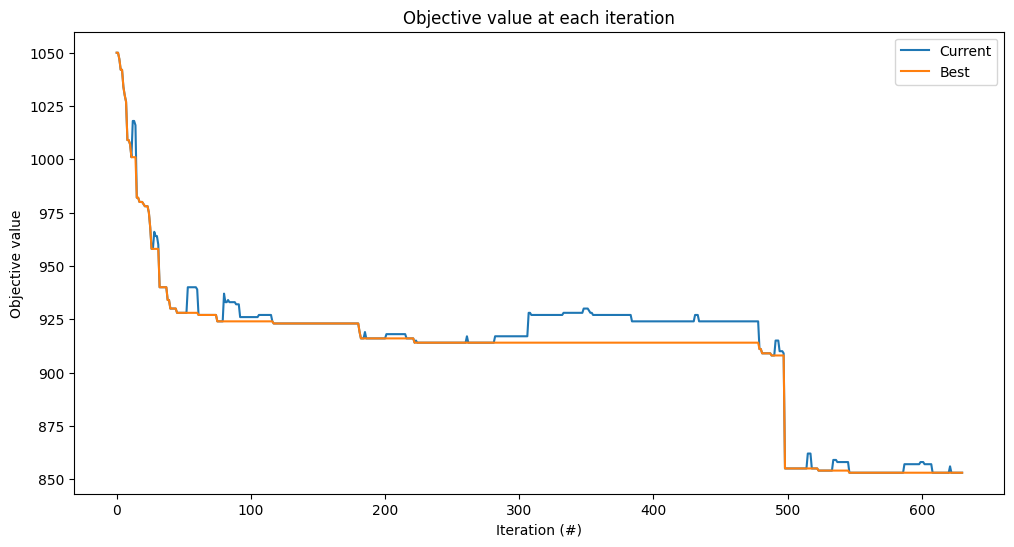

In [18]:
_, ax = plt.subplots(figsize=(12, 6))
result.plot_objectives(ax=ax)